In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import utils

plt.style.use("ggplot")

# Improving suspended sediment coefficients in TEOTIL3

## Notebook 03: Statistical models

Notebook 02 estimated annual SS fluxes for a range of stations in Norway. This notebook tests various statistical models using subsets of these data.
    
## 1. User options

Set the options below to filter the data before fitting models.

In [2]:
# Choose whether to use just NVE data, just Vannmiljø data, or both
# Must be one of ('nve', 'vannmiljø', 'both')
use_data = "both"

# Number of distinct months that must be sampled each year for a station-year
# to be included e.g. if n_months_per_yr = 12, a station must have at least one
# sample per month for a station-year to be kept in the dataset
n_months_per_yr = 6

# Maximum size of catchments (in km2)
upstr_area_thresh = 1000

# Maximum percentage of catchment area that is 'lake'
lake_pct_thresh = 2

# Maximum percentage of catchment area that is ('urban' + 'agri')
anthrop_pct_thresh = 10

In [3]:
if use_data not in ("nve", "vannmiljø", "both"):
    raise ValueError("'use_data' must be one of ('nve', 'vannmiljø', 'both').")

if not isinstance(n_months_per_yr, int) or not (1 <= n_months_per_yr <= 12):
    raise ValueError("'n_months_per_yr' must be an integer between 1 and 12.")

if not (0 <= lake_pct_thresh <= 100):
    raise ValueError("'lake_pct_thresh' must be a value between 0 and 100.")

if not (0 <= anthrop_pct_thresh <= 100):
    raise ValueError("'lake_pct_thresh' must be a value between 0 and 100.")

## 2. Read data

In [4]:
# Read data
dir_path = r"/home/jovyan/shared/common/teotil3/nve_ss_data"
cat_gdf = gpd.read_file(os.path.join(dir_path, "filtered_catchments.gpkg"))
flux_df = pd.read_csv(os.path.join(dir_path, "ss_fluxes.csv"))
q_df = pd.read_csv(os.path.join(dir_path, "flows_gts-api.csv"))
wc_df = pd.read_excel(os.path.join(dir_path, "filtered_data.xlsx"), sheet_name="data")
q_df["date"] = pd.to_datetime(q_df["date"])

# Filter data based on catchment properties
filter_str = (
    f"(area_km2 <= {upstr_area_thresh}) and "
    f"(a_lake_pct <= {lake_pct_thresh}) and "
    f"(a_anthrop_pct <= {anthrop_pct_thresh})"
)
if use_data == "nve":
    filter_str += " and (source == 'NVE')"
elif use_data == "vannmiljø":
    filter_str += " and (source == 'Vannmiljø')"
else:
    pass
cat_gdf = cat_gdf.query(filter_str)
cat_stn_list = set(cat_gdf["station_id"].unique())

# Filter based on sampling frequency
wc_df["year"] = wc_df["date"].dt.year
wc_df["month"] = wc_df["date"].dt.month
wc_df = wc_df.groupby(["station_id", "year"]).filter(
    lambda x: x["month"].nunique() >= n_months_per_yr
)
wc_df = wc_df.drop(columns=["year", "month"]).reset_index(drop=True)
samp_stn_list = set(wc_df["station_id"].unique())

# Filter based on availability of flux estimates
flux_stn_list = set(flux_df["station_id"].unique())

# Get stations meeting all criteria
stn_list = list(cat_stn_list & samp_stn_list & flux_stn_list)

# Filter to stations of interest
cat_gdf = cat_gdf.query("station_id in @stn_list")
flux_df = flux_df.query("station_id in @stn_list")
q_df = q_df.query("station_id in @stn_list")
wc_df = wc_df.query("station_id in @stn_list")

# Calculate annual flows
q_df["year"] = q_df["date"].dt.year
q_df["flow_m3"] = q_df["flow_m3/s"] * 24 * 60 * 60
del q_df["date"], q_df["flow_m3/s"]
q_df = q_df.groupby(["station_id", "year"]).sum().reset_index()

# Combine datasets
df = pd.merge(flux_df, q_df, how="inner", on=["station_id", "year"])
df = pd.merge(df, cat_gdf, how="left", on="station_id").drop(columns="geometry")

print(f"Data from {len(stn_list)} stations and {len(df)} station-years in the dataset.")

nivapy.spatial.quickmap(
    df, lon_col="lon", lat_col="lat", popup="station_id", cluster=True
)

Data from 36 stations and 201 station-years in the dataset.


## 3. Statistical models

Background SS losses in TEOTIL3 are currently estimated using coefficients from Bogen (1996) as:

$$L_i = C_{fjell} A_{fjell} + C_{skog} A_{skog} + C_{bre} A_{bre}$$

where $L_i$ is the annual SS load in year $i$ (in kg), the $A_x$ are the areas of each land cover class in the catchment (in $km^2$), and: 

 * $C_{fjell} = 10000 \quad kg/km^2$
 * $C_{skog} = 1000 \quad kg/km^2$
 * $C_{bre} = 130000 \quad kg/km^2$

In other words, the estimates do not vary over time. One option is to continue using this model, perhaps with updated coefficients. My preferred option would be to switch to concentration-based coefficients that vary with runoff:

$$L_i = R_i (C_{fjell} A_{fjell} + C_{skog} A_{skog} + C_{bre} A_{bre})$$

where $L_i$ and $A_i$ area as above; $R_i$ is the annual runoff for the catchment in year $i$ (in mm); and the $C_x$ are now concentration-based coefficients for each land class (in mg/l).

Note that a more instructive way to fit this might be to calculate runoff-normalised annual fluxes and actually fit:

$$\frac{L_i}{R_i} = C_{fjell} A_{fjell} + C_{skog} A_{skog} + C_{bre} A_{bre}$$

**Note:** Fitting with statsmodels is simple and provides detailed output, but it lack some useful options. In particular, for the work here it is useful to be able to use Non-Negative Least Squares (NNLS), because most physically sensible models will have positive coefficients. With help from Copilot, I have created a function called `linear_regression_summary` (in `utils.py`), which includes options for fitting non-negative coefficients and producing simple diagnostic plots. In the examples below, I've used both statsmodels and my function to check the output is always the same. So far, results from my function seem reliable, but **use with caution**.

In [5]:
# Calculate useful parameters
df["runoff_mm"] = 1000 * df["flow_m3"] / (1e6 * df["area_km2"])
df["SS_mgpl"] = (
    1e6 * df["SS_kg"] / (1000 * df["flow_m3"])
)  # Flow-weighted mean annual conc.
df["LdivR"] = df["SS_kg"] / df["runoff_mm"]  # Load in kg / runoff in mm
df["RA_upland"] = df["a_upland_km2"] * df["runoff_mm"]  # Runoff in mm x area in km2
df["RA_wood"] = df["a_wood_km2"] * df["runoff_mm"]  # Runoff in mm x area in km2
df["RA_glacier"] = df["a_glacier_km2"] * df["runoff_mm"]  # Runoff in mm x area in km2
del df["flow_m3"]

# Tidy
cols = [
    "source",
    "station_id",
    "station_name",
    "lon",
    "lat",
    "year",
    "SS_kg",
    "SS_mgpl",
    "LdivR",
    "runoff_mm",
    "area_km2",
    "a_agri_km2",
    "a_glacier_km2",
    "a_lake_km2",
    "a_upland_km2",
    "a_urban_km2",
    "a_wood_km2",
    "RA_upland",
    "RA_wood",
    "RA_glacier",
]
df = df[cols]
df.head()

,source,station_id,station_name,lon,lat,year,SS_kg,SS_mgpl,LdivR,runoff_mm,area_km2,a_agri_km2,a_glacier_km2,a_lake_km2,a_upland_km2,a_urban_km2,a_wood_km2,RA_upland,RA_wood,RA_glacier
0,Vannmiljø,001-30745,Enningdalselva (ENI 2),11.490473,58.960694,1991,162394.714208,1.956641,412.177271,393.992405,210.655557,5.104657,0.0,3.487777,5.180024,0.080217,71.814923,2040.890155,28294.534245,0.0
1,Vannmiljø,001-30745,Enningdalselva (ENI 2),11.490473,58.960694,2009,260322.709569,2.568778,541.127435,481.074684,210.655557,5.104657,0.0,3.487777,5.180024,0.080217,71.814923,2491.978456,34548.341371,0.0
2,Vannmiljø,001-30745,Enningdalselva (ENI 2),11.490473,58.960694,2010,212525.611163,2.563757,540.069651,393.515190,210.655557,5.104657,0.0,3.487777,5.180024,0.080217,71.814923,2038.418169,28260.263073,0.0
3,Vannmiljø,001-30745,Enningdalselva (ENI 2),11.490473,58.960694,2011,289501.645126,2.231686,470.117042,615.807595,210.655557,5.104657,0.0,3.487777,5.180024,0.080217,71.814923,3189.898185,44224.175033,0.0
4,Vannmiljø,001-30745,Enningdalselva (ENI 2),11.490473,58.960694,2012,265178.629155,2.203958,464.276080,571.165823,210.655557,5.104657,0.0,3.487777,5.180024,0.080217,71.814923,2958.652729,41018.229602,0.0


### 3.1. Explore data

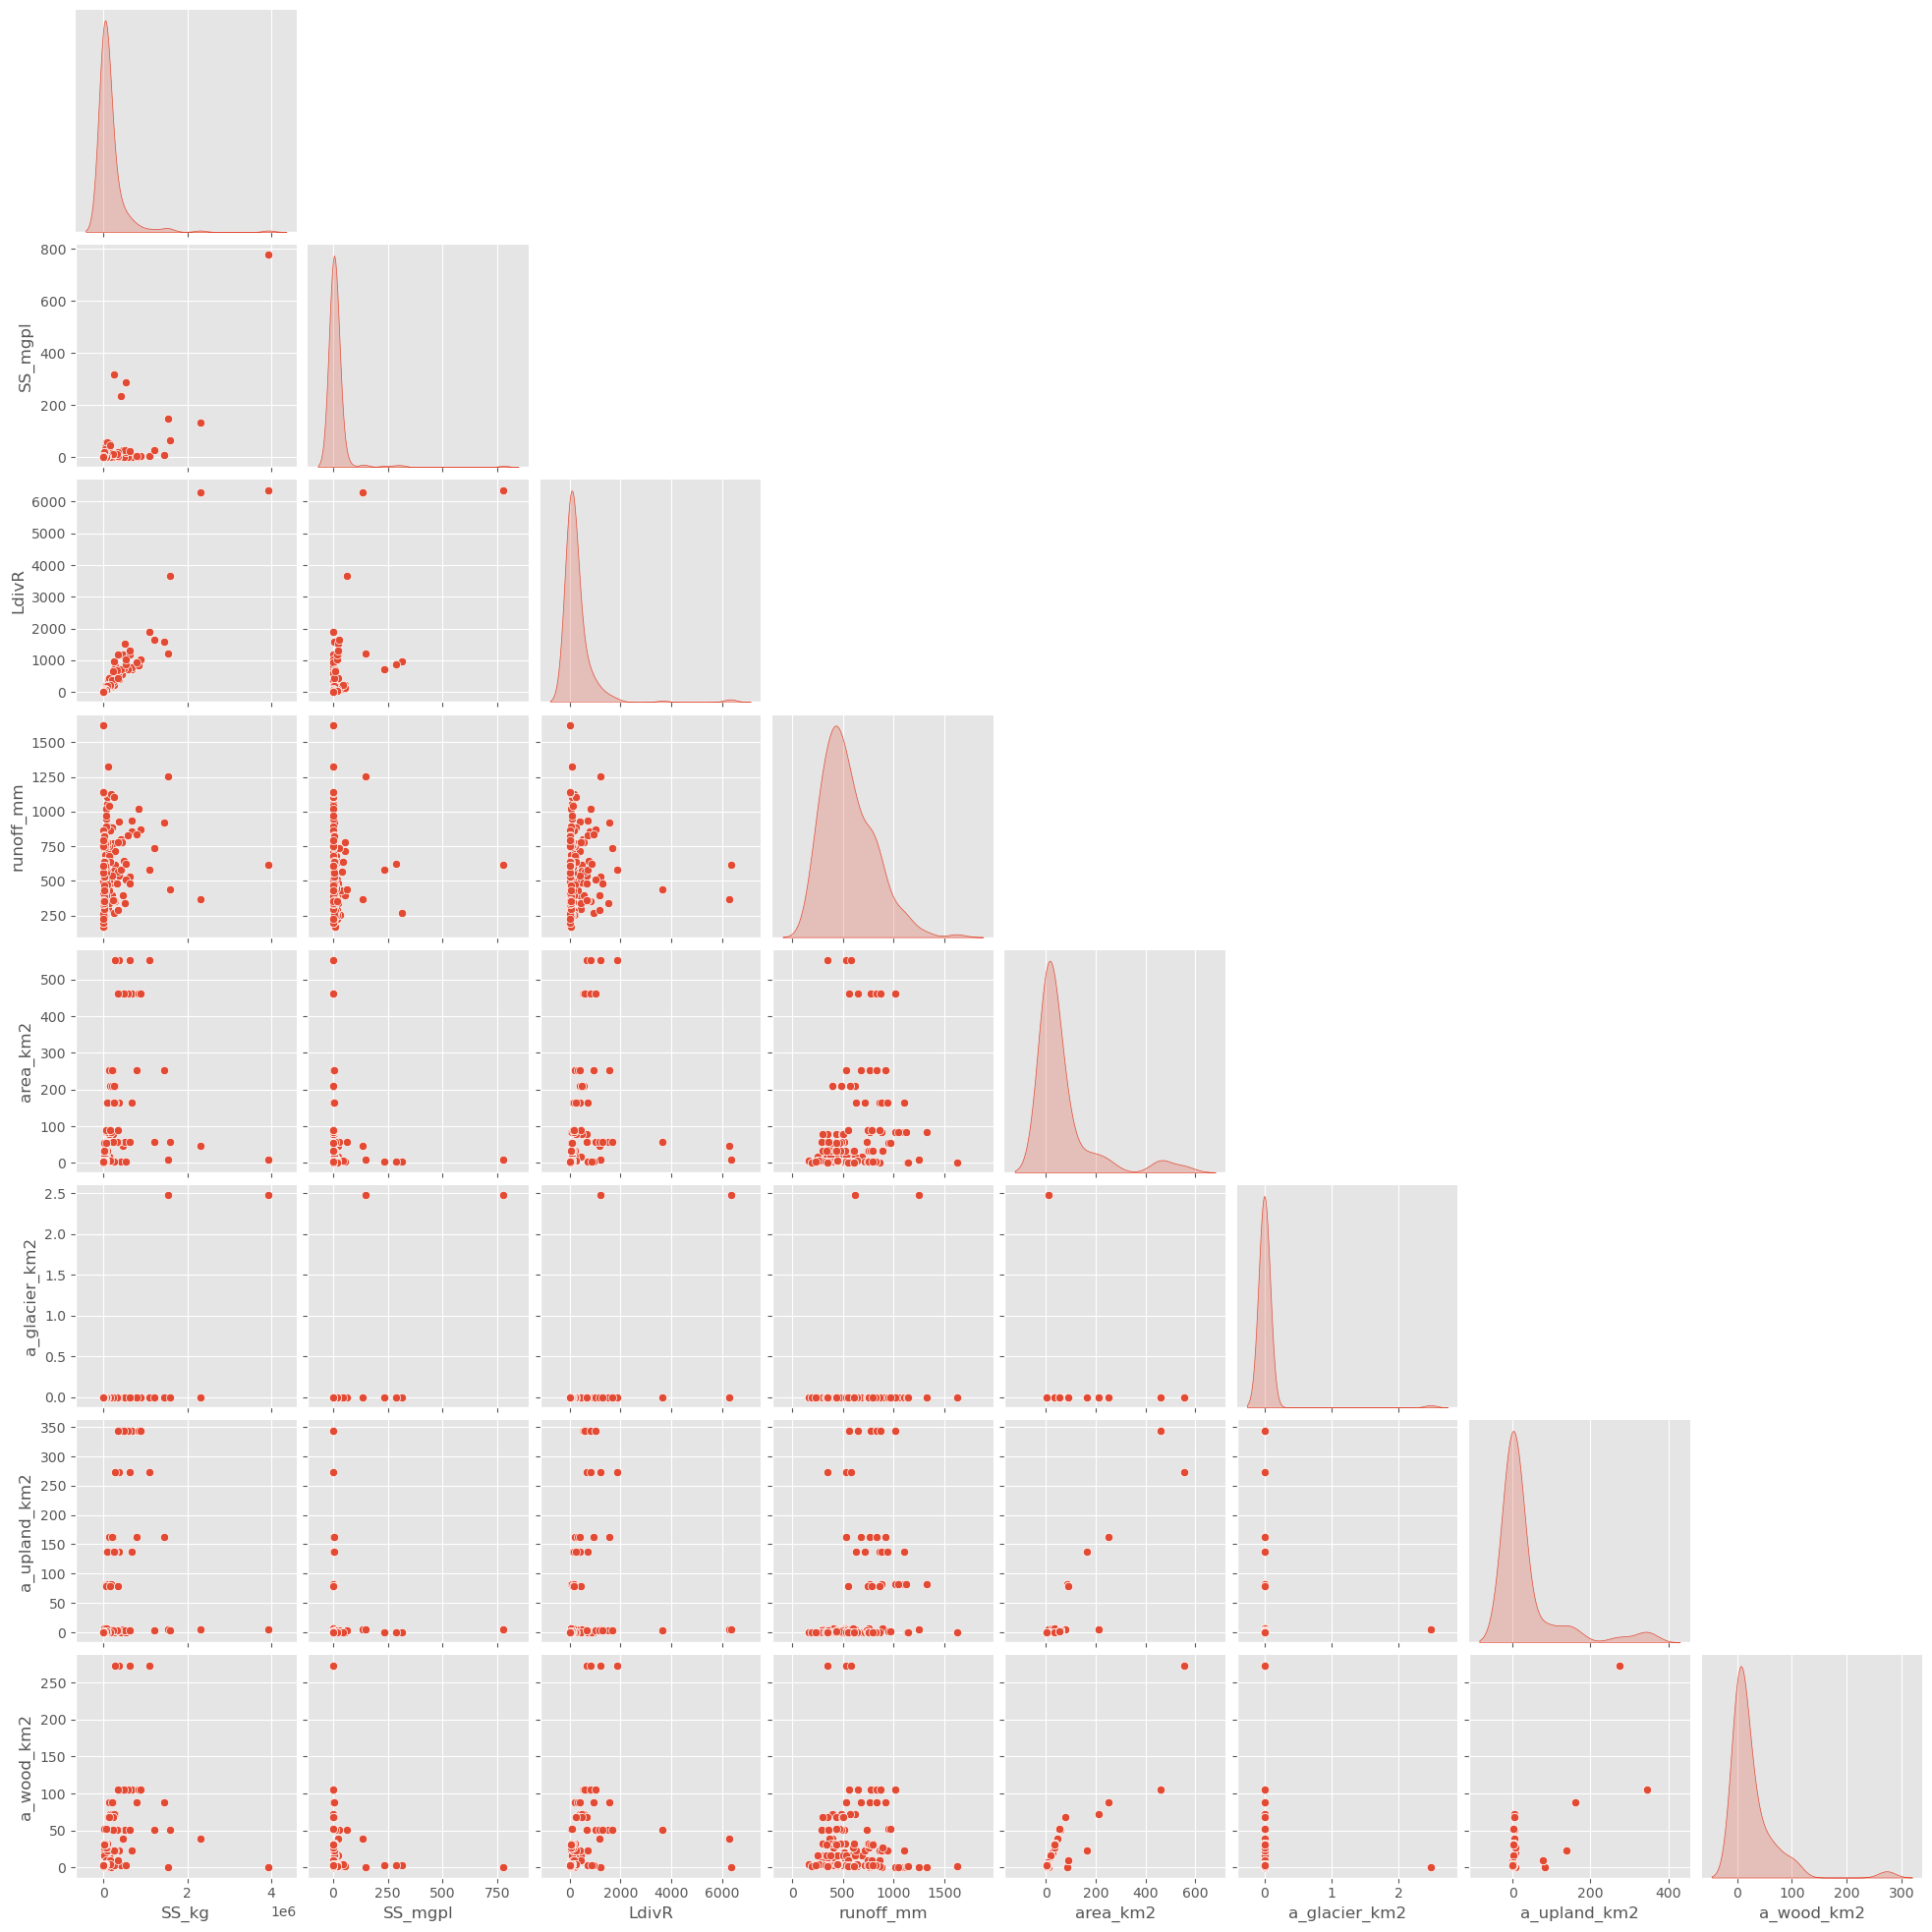

In [6]:
cols = [
    "SS_kg",
    "SS_mgpl",
    "LdivR",
    "runoff_mm",
    "area_km2",
    "a_glacier_km2",
    "a_upland_km2",
    "a_wood_km2",
]
sn.pairplot(df[cols], corner=True, diag_kind="kde", kind="scatter")

### 3.2. Total catchment area only

A trivial model that isn't very useful, but a good starting point for reference.

In [7]:
# Predict SS from catchment area
formula = "SS_kg ~ area_km2 - 1"
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  SS_kg   R-squared (uncentered):                   0.206
Model:                            OLS   Adj. R-squared (uncentered):              0.202
Method:                 Least Squares   F-statistic:                              52.02
Date:                Wed, 18 Jun 2025   Prob (F-statistic):                    1.11e-11
Time:                        12:51:32   Log-Likelihood:                         -2873.2
No. Observations:                 201   AIC:                                      5748.
Df Residuals:                     200   BIC:                                      5752.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

=== Linear Regression Summary ===
R²:          0.2064
Adjusted R²: 0.2024
AIC:         5748.4

Coefficients:
area_km2: 1433.54 (p-value: 0.0000, 95% CI: [1041.62, 1825.47])


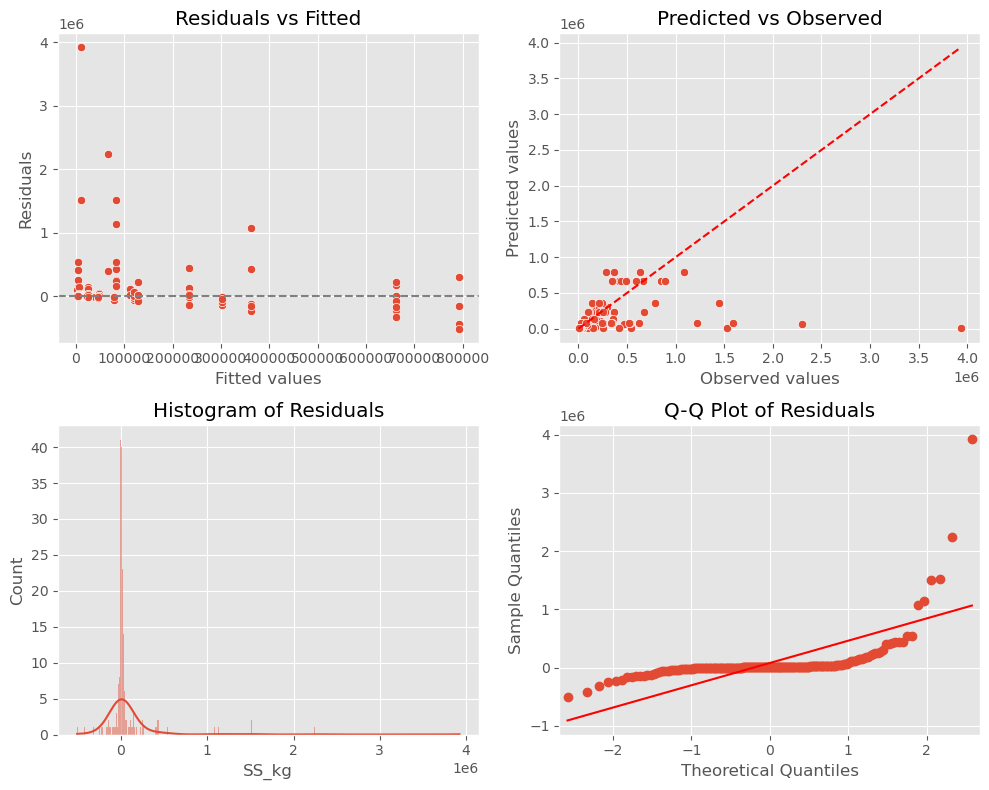

In [8]:
utils.linear_regression_summary(
    data=df,
    pred_vars=["area_km2"],
    resp_var="SS_kg",
    positive=False,
    fit_intercept=False,
    plot=True,
)

### 3.2. Catchment area and runoff

In [9]:
# Predict SS from catchment area and runoff
formula = "SS_kg ~ area_km2 + runoff_mm - 1"
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  SS_kg   R-squared (uncentered):                   0.254
Model:                            OLS   Adj. R-squared (uncentered):              0.247
Method:                 Least Squares   F-statistic:                              33.95
Date:                Wed, 18 Jun 2025   Prob (F-statistic):                    2.06e-13
Time:                        12:51:34   Log-Likelihood:                         -2866.9
No. Observations:                 201   AIC:                                      5738.
Df Residuals:                     199   BIC:                                      5744.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

=== Linear Regression Summary ===
R²:          0.2544
Adjusted R²: 0.2469
AIC:         5737.8

Coefficients:
area_km2: 1007.99 (p-value: 0.0000, 95% CI: [560.76, 1455.22])
runoff_mm: 185.35 (p-value: 0.0004, 95% CI: [83.24, 287.45])


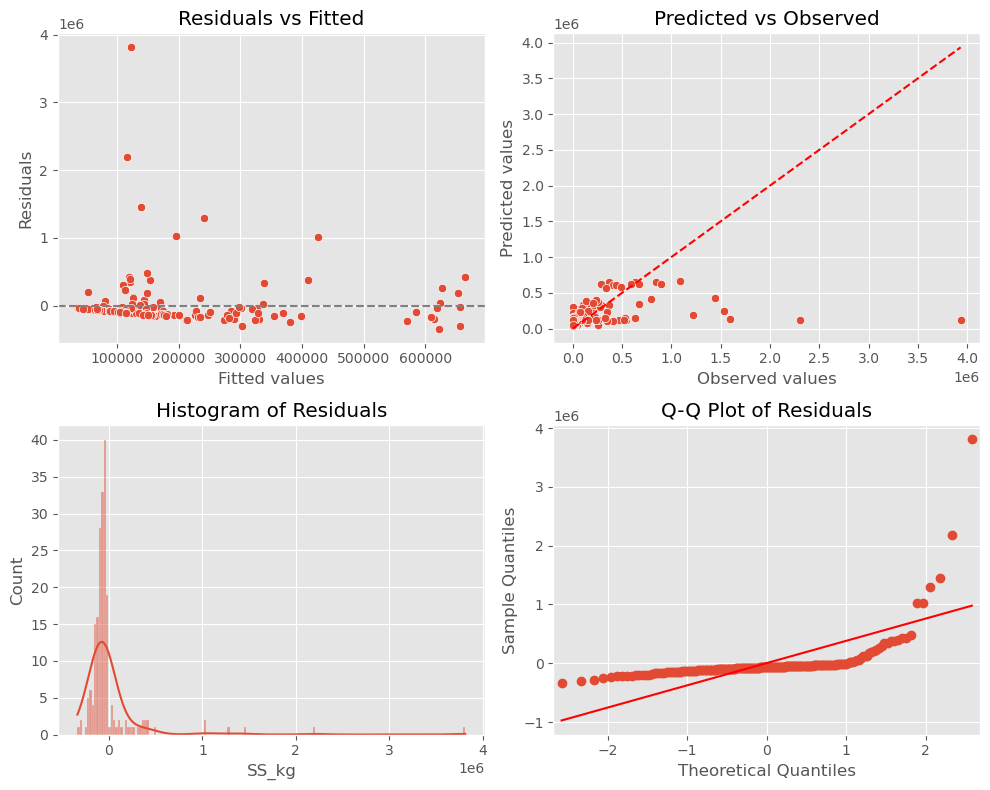

In [10]:
utils.linear_regression_summary(
    data=df,
    pred_vars=["area_km2", "runoff_mm"],
    resp_var="SS_kg",
    positive=False,
    fit_intercept=False,
    plot=True,
)

### 3.3. Bogen (1996)

Fit

$$L_i = C_{fjell} A_{fjell} + C_{skog} A_{skog} + C_{bre} A_{bre}$$

where $C_x$ are coefficients in kg/km2.

**Note:** My original approach in `01_get_ss_data.ipynb` was based on individual lake sizes with the following parameters:

    n_months_per_yr = 12
    upstr_area_thresh = 1000  # km2
    upstr_lake_thresh = 5  # km2
    anthrop_pct_thresh = 10

This gives a model with an R2 of 27%. `a_upland_km2` and `a_wood_km2` are both significant at $p < 0.05$, and `a_glacier_km2` has $p < 0.10$. The coefficients are all positive and broadly compatible with the original estimates from Bogen:

 * $C_{fjell} = 10780 \quad kg/km^2$
 * $C_{skog} = 4873 \quad kg/km^2$
 * $C_{bre} = 86080 \quad kg/km^2$

This seems like a good starting point.

In [11]:
# Predict SS using static, area-based coefficients
formula = "SS_kg ~ a_upland_km2 + a_wood_km2 + a_glacier_km2 - 1"
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  SS_kg   R-squared (uncentered):                   0.597
Model:                            OLS   Adj. R-squared (uncentered):              0.591
Method:                 Least Squares   F-statistic:                              97.85
Date:                Wed, 18 Jun 2025   Prob (F-statistic):                    7.03e-39
Time:                        12:51:35   Log-Likelihood:                         -2805.0
No. Observations:                 201   AIC:                                      5616.
Df Residuals:                     198   BIC:                                      5626.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

=== Linear Regression Summary ===
R²:          0.5972
Adjusted R²: 0.5911
AIC:         5616.1

Coefficients:
a_upland_km2: 773.30 (p-value: 0.0206, 95% CI: [119.97, 1426.64])
a_wood_km2: 2775.11 (p-value: 0.0000, 95% CI: [1652.13, 3898.09])
a_glacier_km2: 1102221.96 (p-value: 0.0000, 95% CI: [944213.39, 1260230.54])


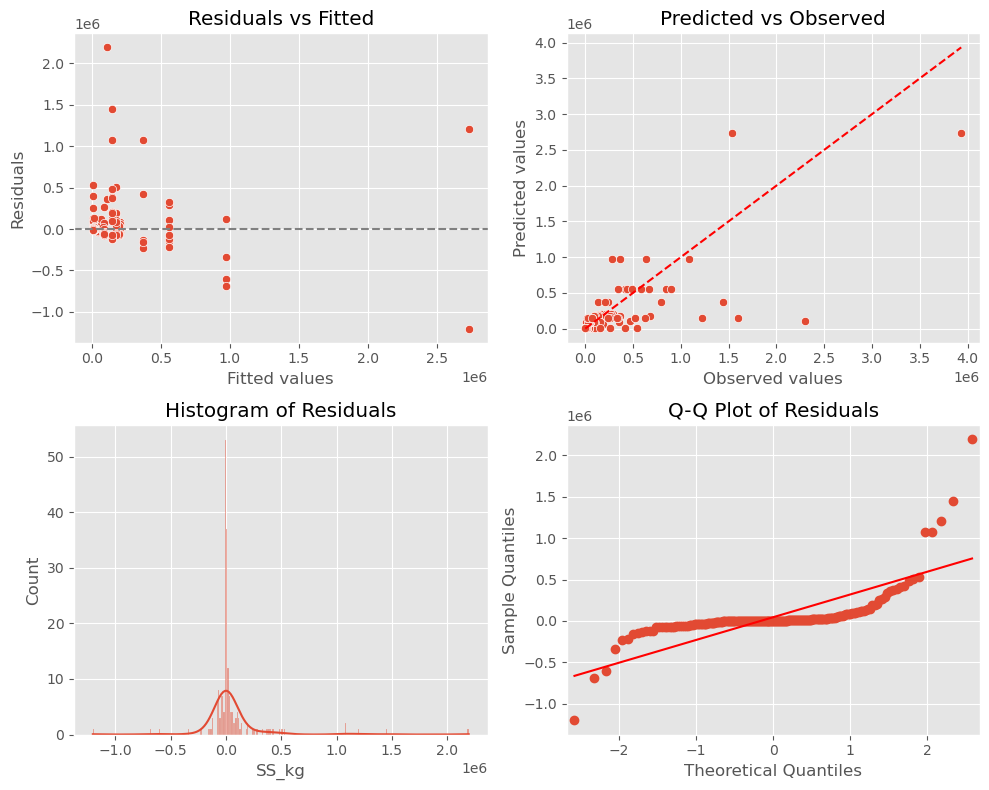

In [12]:
utils.linear_regression_summary(
    data=df,
    pred_vars=['a_upland_km2', 'a_wood_km2', 'a_glacier_km2'],
    resp_var="SS_kg",
    positive=False,
    fit_intercept=False,
    plot=True,
)

### 2.3. Concentration-based

Fit

$$L_i = R_i (C_{fjell} A_{fjell} + C_{skog} A_{skog} + C_{bre} A_{bre})$$

where $C_x$ are coefficients in mg/l.

**Note:** My original approach in `01_get_ss_data.ipynb` was based on individual lake sizes with the following parameters:

    n_months_per_yr = 12
    upstr_area_thresh = 1000  # km2
    upstr_lake_thresh = 5  # km2
    anthrop_pct_thresh = 10
    
This model is slightly worse than the one from Bogen: R2 is 16% and the AIC value is about 50 units higher. The coefficient for `wood` is not statistically significant, but the "raw" results suggest the following:

 * $C_{fjell} = 4.8 \quad mg/l$
 * $C_{skog} = 1.6 \quad mg/l$
 * $C_{bre} = 53.8 \quad mg/l$

It would be interesting to check whether these estimates are reasonable.

In [13]:
formula = "SS_kg ~ RA_upland + RA_wood + RA_glacier - 1"
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  SS_kg   R-squared (uncentered):                   0.483
Model:                            OLS   Adj. R-squared (uncentered):              0.475
Method:                 Least Squares   F-statistic:                              61.69
Date:                Wed, 18 Jun 2025   Prob (F-statistic):                    3.33e-28
Time:                        12:51:37   Log-Likelihood:                         -2830.1
No. Observations:                 201   AIC:                                      5666.
Df Residuals:                     198   BIC:                                      5676.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

=== Linear Regression Summary ===
R²:          0.4831
Adjusted R²: 0.4753
AIC:         5666.2

Coefficients:
RA_upland: 0.56 (p-value: 0.2695, 95% CI: [-0.44, 1.57])
RA_wood: 5.83 (p-value: 0.0000, 95% CI: [3.57, 8.08])
RA_glacier: 899.14 (p-value: 0.0000, 95% CI: [717.95, 1080.34])


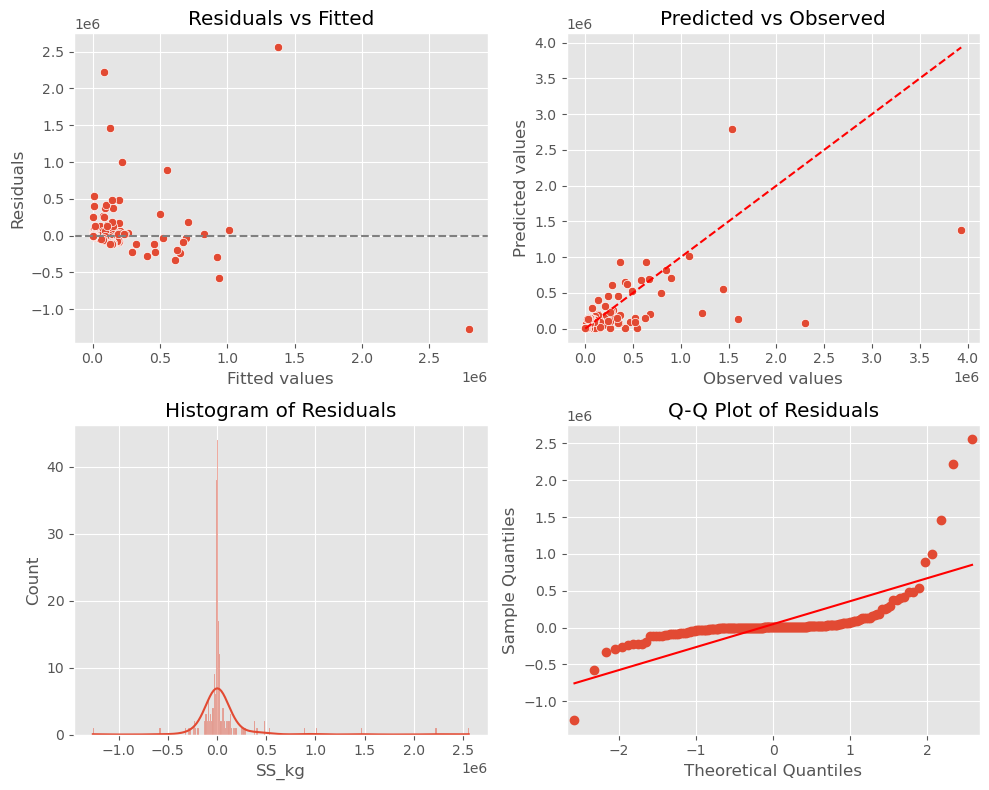

In [14]:
utils.linear_regression_summary(
    data=df,
    pred_vars=['RA_upland', 'RA_wood', 'RA_glacier'],
    resp_var="SS_kg",
    positive=False,
    fit_intercept=False,
    plot=True,
)

## 3. Ideas to explore

 * Check whether the estimated typical concentrations from the model above match mean concentrations measured in catchments dominated by forests/glaciers/uplands.
   
 * Explore different filter parameters to balance total number of data points with catchment suitability (i.e. "naturalness"). This should be much easier/faster now that the filtering happens in this notebook (section 1).
   
 * I suspect there may be issues with collinearity in these models, especially when the filtered dataset contains relatively few data points. Try Ridge Regression to stabilise parameter estimates?